<h1 style="font-size:2.5rem;color:purple;">Artificial Intelligence II</h1>
<h1 style="font-size:1.5rem;color:purple;">Deep Learning for Natural Language Processing (NLP)</h1>

In this assignment, we develop a sentiment classifier using only **Logistic Regression** and only **TF-IDF** in Python on a given Twitter dataset.  
The dataset consists of three files: *train_dataset.csv, val_dataset.csv, test_dataset.csv*.  
Train and Val consists of three columns: **ID, Text, Label**, and Test consists of two columns: **ID, Text**.

In [51]:
# Import libraries

import pandas as pd

import warnings

import re

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import matplotlib.pyplot as plt

from wordcloud import WordCloud

In [5]:
# Ingore warnings
warnings.filterwarnings("ignore")

First we load the given data (*test.csv* to use for training the model, *val.csv* to use for validation of training and *test.csv* to use for predictions)

In [6]:
# Read train dataset (to use for training)
df_train = pd.read_csv('datasets/train_dataset.csv')

# Read val dataset (to use for validation of training)
df_val = pd.read_csv('datasets/val_dataset.csv')

# Read test dataset (to use for predictions)
df_test = pd.read_csv('datasets/test_dataset.csv')

Let's take a look at the train dataset (the other two datasets have a similar structure to this one)

In [7]:
df_train

,ID,Text,Label
0,189385,@whoisralphie dude I'm so bummed ur leaving!,0
1,58036,"oh my god, a severed foot was foun in a wheely...",0
2,190139,I end up &quot;dog dialing&quot; sumtimes. Wha...,1
3,99313,@_rachelx meeeee toooooo!,0
4,157825,"I was hoping I could stay home and work today,...",0
...,...,...,...
148383,99894,just love the jonas brothers its tooo bad i w...,0
148384,61015,another day gone by....time is moving so fast...,0
148385,36598,"fuck college, i'm just gonna marry rich. : fuc...",1
148386,83799,ZOMGZ NEW SONG FTW. remember that night. &lt;3,1


<h1 style="font-size:1.5rem;color:purple;">Data Preprocessing</h1>

In this section we clean the datasets. First remove duplicate values, then remove unwanted symbols/characters (e.g. URLs, @mentions, numbers/characters) and convert every letter to lowercase.

In [8]:
# Drop duplicate values 
df_train = df_train.drop_duplicates().reset_index(drop=True)
df_val = df_val.drop_duplicates().reset_index(drop=True)
df_test = df_test.drop_duplicates().reset_index(drop=True)

Function to clean a text

In [9]:
# Function to clean text

def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    # Remove mentions/usernames
    text = re.sub(r'@\w+', '', text)
    # Remove numbers and characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower()

    return text


# Clean only Text column
df_train['Text'] = df_train['Text'].apply(clean_text)
df_val['Text'] = df_val['Text'].apply(clean_text)
df_test['Text'] = df_train['Text'].apply(clean_text)

Drop rows with NaN values

In [10]:
# Drop NaN values
df_train = df_train.replace(r'^\s*$', pd.NA, regex=True).dropna()
df_val = df_val.replace(r'^\s*$', pd.NA, regex=True).dropna()
df_test = df_test.replace(r'^\s*$', pd.NA, regex=True).dropna()

Now take a look at the same dataset as above, but cleaned (the other two datasets are cleaned as well)

In [11]:
df_train

,ID,Text,Label
0,189385,dude im so bummed ur leaving,0
1,58036,oh my god a severed foot was foun in a wheely ...,0
2,190139,i end up quotdog dialingquot sumtimes whats do...,1
3,99313,meeeee toooooo,0
4,157825,i was hoping i could stay home and work today ...,0
...,...,...,...
148383,99894,just love the jonas brothers its tooo bad i w...,0
148384,61015,another day gone bytime is moving so fast,0
148385,36598,fuck college im just gonna marry rich fuck co...,1
148386,83799,zomgz new song ftw remember that night lt,1


Remove stopwords (this action keeps only the necessary words from a text and helps to ease the training of the model)

In [12]:
# Download stopwords
nltk.download('stopwords')

# Load english stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/christina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Function to remove stopwords from a text

In [14]:
# Function to remove stopwords from a text

def remove_stopwords(text):

    words = text.split()  # Separate text into words
    filtered_words = [word for word in words if word.lower() not in stop_words]  # Remove stopwords
    clean_text = ' '.join(filtered_words)  # Join separated words into a text
    return clean_text

Remove stopwords from all three datasets

In [15]:
df_train['Text'] = df_train['Text'].apply(remove_stopwords)
df_val['Text'] = df_val['Text'].apply(remove_stopwords)
df_test['Text'] = df_test['Text'].apply(remove_stopwords)

Drop rows with NaN values (some rows may be empty after removing stopwords)

In [16]:
# Drop NaN values
df_train = df_train.replace(r'^\s*$', pd.NA, regex=True).dropna()
df_val = df_val.replace(r'^\s*$', pd.NA, regex=True).dropna()
df_test = df_test.replace(r'^\s*$', pd.NA, regex=True).dropna()

Set word lemmatizer (this action transform words into their base or root forms)

In [17]:
# Create Lemmatizer
lemmatizer = WordNetLemmatizer()

Function for lemmatization in a text

In [18]:
# Function for lemmatization in a text

def lemmatize_text(text):
    words = text.split()  # Separate text into words
    lemmatized_text = " ".join([lemmatizer.lemmatize(word, pos="v") for word in words])  # Lemmatize words
    return lemmatized_text

Lemmatize every word in Text column of the dataframes

In [19]:
df_train['Text'] = df_train['Text'].apply(lemmatize_text)
df_val['Text'] = df_val['Text'].apply(lemmatize_text)
df_test['Text'] = df_test['Text'].apply(lemmatize_text)

Create some wordclouds to make it clear and visible which words are used more often

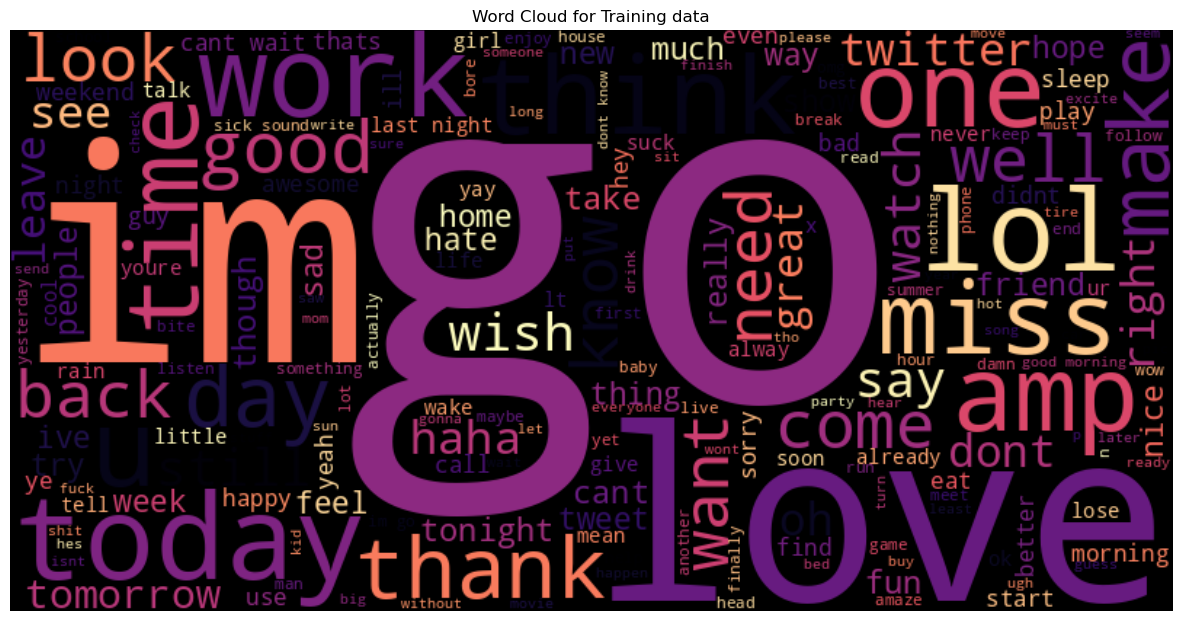

In [ ]:
# Wordcloud for TRAINING DATA

# Combine all text entries into one string
text = " ".join(df_train['Text'])

# Create a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='magma').generate(text)

# Show the word cloud
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Word Cloud for Training data")
plt.axis("off")
plt.show()

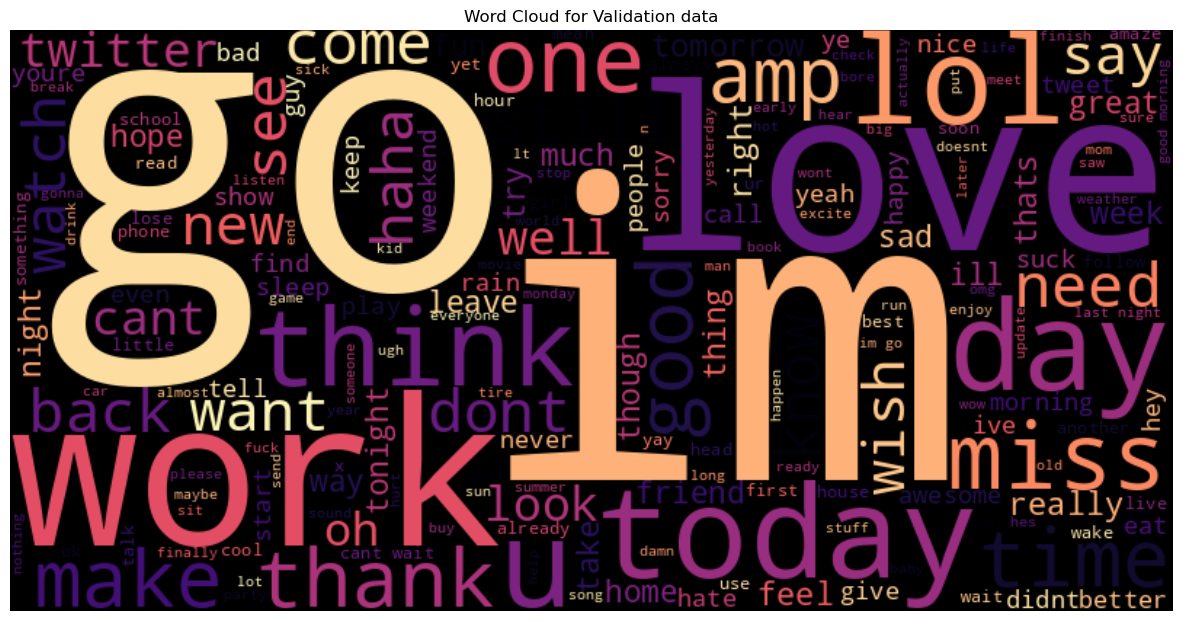

In [49]:
# Wordcloud for VALIDATION DATA

# Combine all text entries into one string
text = " ".join(df_val['Text'])

# Create a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='magma').generate(text)

# Show the word cloud
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Word Cloud for Validation data")
plt.axis("off")
plt.show()

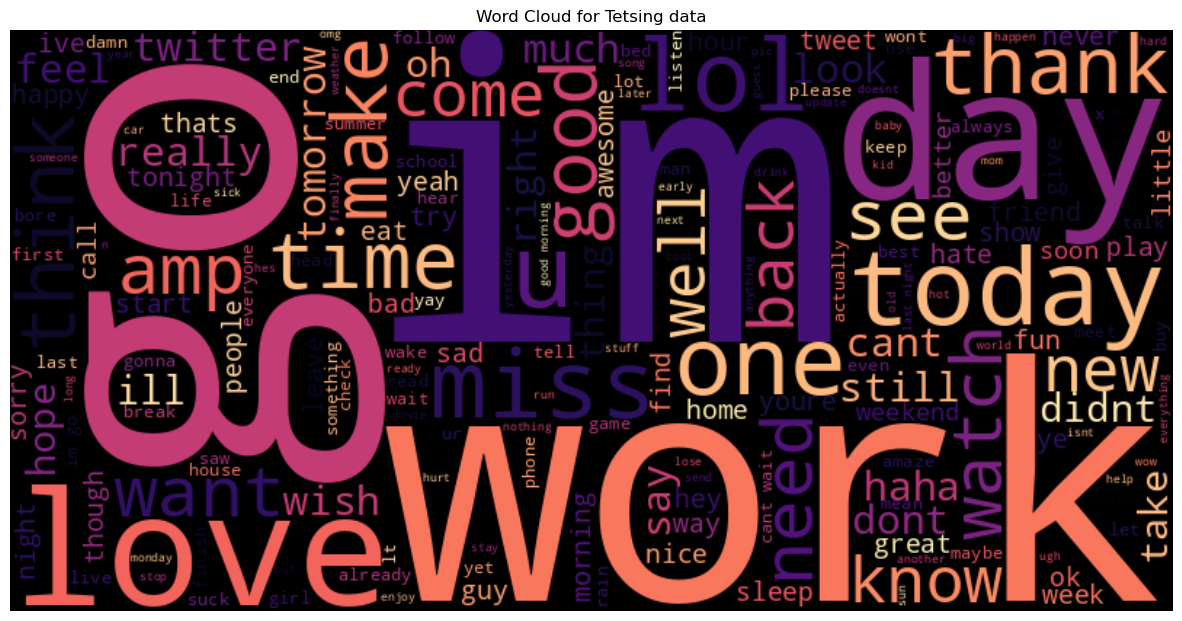

In [52]:
# Wordcloud for TESTING DATA

# Combine all text entries into one string
text = " ".join(df_test['Text'])

# Create a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='magma').generate(text)

# Show the word cloud
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Word Cloud for Tetsing data")
plt.axis("off")
plt.show()